In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# # Check the file type to determine proper extraction method
!file "/content/gdrive/MyDrive/hw1-data.tar"

/content/gdrive/MyDrive/hw1-data.tar: POSIX tar archive (GNU)


In [5]:
!tar -xf "/content/gdrive/MyDrive/hw1-data.tar" -C "/content/gdrive/MyDrive/"

In [ ]:
!ls -la "/content/gdrive/MyDrive/data/"
# # And check subfolders
!ls -la "/content/gdrive/MyDrive/data/train/" | head
!ls -la "/content/gdrive/MyDrive/data/val/" | head
!ls -la "/content/gdrive/MyDrive/data/test/" | head

In [7]:
# # Copy data from Google Drive to Colab local storage
!mkdir -p /content/local_data
!cp -r "/content/gdrive/MyDrive/data/train" "/content/local_data/"
!cp -r "/content/gdrive/MyDrive/data/val" "/content/local_data/"
!cp -r "/content/gdrive/MyDrive/data/test" "/content/local_data/"

In [8]:
!find "/content/local_data/" -type f | wc -l

23368


In [ ]:
!cp -r "/content/gdrive/MyDrive/prediction-SAMPLE.csv" "/content/local_data/"

In [9]:
# Keep Colab from disconnecting
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){
    console.log("Clicking connect button");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect, 60000);
'''))

<IPython.core.display.Javascript object>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, ResNet101_Weights, resnet101
from tqdm.notebook import tqdm
import IPython
from IPython.display import display

# Data location for project
data_root = '/content/local_data'
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

In [11]:
# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda:0
GPU: Tesla T4


In [12]:
class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []

        if not is_test:
            # For train and validation folders
            for class_id in range(100):
                class_dir = os.path.join(root_dir, str(class_id))
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith(('.jpg', '.jpeg', '.png')):
                            self.images.append(os.path.join(class_dir, img_name))
                            self.labels.append(class_id)
        else:
            # For test folder (no subfolders, just images)
            for img_name in os.listdir(root_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(root_dir, img_name))
                    self.labels.append(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            img_name = os.path.basename(img_path)
            return image, img_name
        else:
            label = self.labels[idx]
            return image, label

In [19]:
# Data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Add some rotation augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageClassificationDataset(train_dir, transform=train_transform)
val_dataset = ImageClassificationDataset(val_dir, transform=val_transform)
test_dataset = ImageClassificationDataset(test_dir, transform=val_transform, is_test=True)

# Check dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create DataLoaders for each dataset
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

Training dataset size: 20724
Validation dataset size: 300
Test dataset size: 2344


In [20]:
def get_resnet_model(num_classes=100, model_name='resnet101'):
    if model_name == 'resnet101':
        model = resnet101(weights=ResNet101_Weights.DEFAULT)

    # Check parameters to ensure legality for requirements
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Modify the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

# Initialize the model
model = get_resnet_model(num_classes=100)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Total parameters: 44,549,160


In [21]:
from tqdm.notebook import tqdm
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, checkpoint_dir='/content/gdrive/MyDrive/checkpoints'):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    best_val_acc = 0.0
    best_model_wts = None
    start_epoch = 0

    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Check if checkpoint exists
    latest_checkpoint = None
    for file in os.listdir(checkpoint_dir):
        if file.startswith('checkpoint_epoch_') and file.endswith('.pth'):
            epoch_num = int(file.split('_')[-1].split('.')[0])
            if latest_checkpoint is None or epoch_num > start_epoch:
                latest_checkpoint = os.path.join(checkpoint_dir, file)
                start_epoch = epoch_num

    # Load checkpoint if exists
    if latest_checkpoint:
        print(f"Loading checkpoint from epoch {start_epoch}")
        checkpoint = torch.load(latest_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        if 'history' in checkpoint:
            history = checkpoint['history']
        if 'best_val_acc' in checkpoint:
            best_val_acc = checkpoint['best_val_acc']
        if 'best_model_wts' in checkpoint:
            best_model_wts = checkpoint['best_model_wts']
        start_epoch += 1  # Start from the next epoch

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Keep Colab awake
        if epoch > 0 and epoch % 3 == 0:  # Every 3 epochs
            print("Keeping session alive...")
            javascript_code = """
            function ClickConnect(){
                console.log("Clicking connect button");
                document.querySelector("colab-connect-button").click()
            }
            setInterval(ClickConnect, 60000);
            """
            display(IPython.display.Javascript(javascript_code))

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            batch_loss = loss.item() * inputs.size(0)
            running_loss += batch_loss
            batch_corrects = torch.sum(preds == labels.data).item()
            running_corrects += batch_corrects

            # Update progress bar
            train_pbar.set_postfix({
                'loss': batch_loss / inputs.size(0),
                'acc': batch_corrects / inputs.size(0)
            })

        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = running_corrects / len(train_dataset)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': batch_loss / inputs.size(0),
                    'acc': batch_corrects / inputs.size(0)
                })

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects / len(val_dataset)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Save metrics
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'best_val_acc': best_val_acc,
            'best_model_wts': best_model_wts
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict().copy()
            print(f'New best model with validation accuracy: {best_val_acc:.4f}')

            # Save the best model
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))

        print()

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, history

In [22]:
# Check internet & resource for batch loading
start_time = time.time()
for i, (inputs, labels) in enumerate(train_loader):
    if i == 10:  # Just test loading 10 batches
        break
print(f"Time to load 10 batches: {time.time() - start_time:.2f} seconds")

Time to load 10 batches: 5.67 seconds


Epoch 1/15
----------


Training Epoch 1:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.2605 Acc: 0.4396
Val Loss: 1.8959 Acc: 0.5133
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_0.pth
New best model with validation accuracy: 0.5133

Epoch 2/15
----------


Training Epoch 2:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.4256 Acc: 0.6235
Val Loss: 1.4810 Acc: 0.6300
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_1.pth
New best model with validation accuracy: 0.6300

Epoch 3/15
----------


Training Epoch 3:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.2076 Acc: 0.6774
Val Loss: 1.3026 Acc: 0.6833
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_2.pth
New best model with validation accuracy: 0.6833

Epoch 4/15
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 4:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.0586 Acc: 0.7147
Val Loss: 1.1049 Acc: 0.6733
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_3.pth

Epoch 5/15
----------


Training Epoch 5:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.9385 Acc: 0.7388
Val Loss: 1.0598 Acc: 0.7233
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_4.pth
New best model with validation accuracy: 0.7233

Epoch 6/15
----------


Training Epoch 6:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.8775 Acc: 0.7582
Val Loss: 1.2154 Acc: 0.7000
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_5.pth

Epoch 7/15
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 7:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.8248 Acc: 0.7707
Val Loss: 1.1200 Acc: 0.7400
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_6.pth
New best model with validation accuracy: 0.7400

Epoch 8/15
----------


Training Epoch 8:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.7823 Acc: 0.7824
Val Loss: 0.8441 Acc: 0.7700
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_7.pth
New best model with validation accuracy: 0.7700

Epoch 9/15
----------


Training Epoch 9:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.7549 Acc: 0.7878
Val Loss: 0.9848 Acc: 0.7700
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_8.pth

Epoch 10/15
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 10:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.7093 Acc: 0.7993
Val Loss: 0.9655 Acc: 0.7733
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_9.pth
New best model with validation accuracy: 0.7733

Epoch 11/15
----------


Training Epoch 11:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.6669 Acc: 0.8114
Val Loss: 0.9729 Acc: 0.7633
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_10.pth

Epoch 12/15
----------


Training Epoch 12:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.6339 Acc: 0.8185
Val Loss: 0.9801 Acc: 0.7933
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_11.pth
New best model with validation accuracy: 0.7933

Epoch 13/15
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 13:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.4682 Acc: 0.8671
Val Loss: 0.8586 Acc: 0.8300
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_12.pth
New best model with validation accuracy: 0.8300

Epoch 14/15
----------


Training Epoch 14:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.4184 Acc: 0.8789
Val Loss: 0.9197 Acc: 0.8067
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_13.pth

Epoch 15/15
----------


Training Epoch 15:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.3998 Acc: 0.8864
Val Loss: 0.8668 Acc: 0.8200
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_14.pth



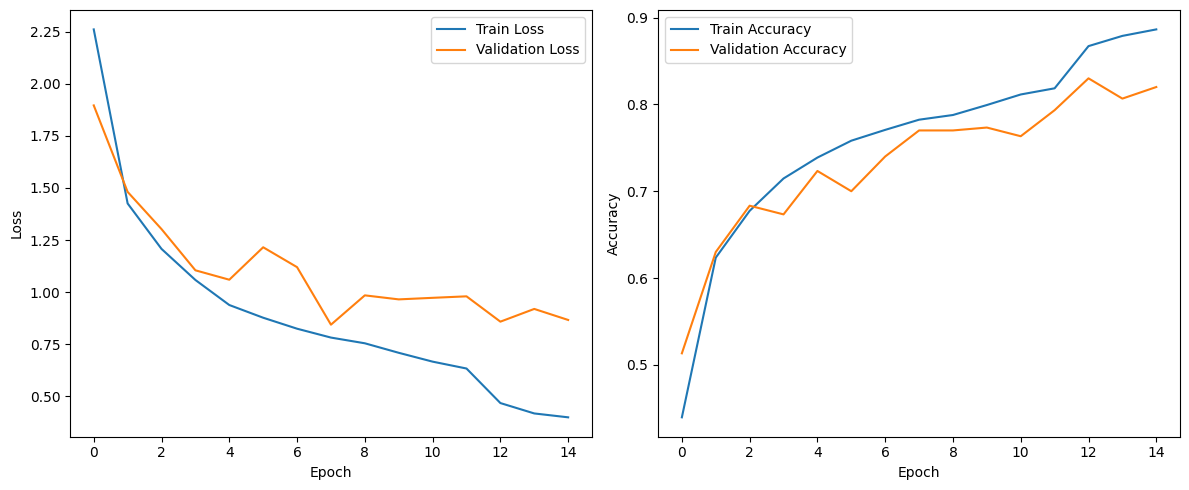

In [23]:
# Train the model
trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=15  # Adjust based on your needs
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Continue training by re-initializing the model, continuing from the best model performance
trained_model = get_resnet_model(num_classes=100)
trained_model = trained_model.to(device)
trained_model.load_state_dict(torch.load('/content/gdrive/MyDrive/checkpoints/best_model.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=5e-4) # Try to change into new learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Get model checkpoint directory and best model
checkpoint_dir = '/content/gdrive/MyDrive/checkpoints'

# Continue the training function with additional epochs
trained_model, history = train_model(
    model=trained_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=25,
    checkpoint_dir=checkpoint_dir
)

Total parameters: 44,549,160
Loading checkpoint from epoch 14


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 16/25
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 16:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.3764 Acc: 0.8916
Val Loss: 0.8861 Acc: 0.8233
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_15.pth

Epoch 17/25
----------


Training Epoch 17:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.3200 Acc: 0.9085
Val Loss: 0.8582 Acc: 0.8433
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_16.pth
New best model with validation accuracy: 0.8433

Epoch 18/25
----------


Training Epoch 18:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2940 Acc: 0.9173
Val Loss: 0.8665 Acc: 0.8400
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_17.pth

Epoch 19/25
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 19:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2871 Acc: 0.9196
Val Loss: 0.8251 Acc: 0.8467
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_18.pth
New best model with validation accuracy: 0.8467

Epoch 20/25
----------


Training Epoch 20:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2770 Acc: 0.9219
Val Loss: 0.7792 Acc: 0.8500
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_19.pth
New best model with validation accuracy: 0.8500

Epoch 21/25
----------


Training Epoch 21:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2675 Acc: 0.9242
Val Loss: 0.8278 Acc: 0.8467
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_20.pth

Epoch 22/25
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 22:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2645 Acc: 0.9262
Val Loss: 0.7874 Acc: 0.8467
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_21.pth

Epoch 23/25
----------


Training Epoch 23:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2505 Acc: 0.9309
Val Loss: 0.8021 Acc: 0.8567
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_22.pth
New best model with validation accuracy: 0.8567

Epoch 24/25
----------


Training Epoch 24:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2496 Acc: 0.9309
Val Loss: 0.8860 Acc: 0.8467
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_23.pth

Epoch 25/25
----------
Keeping session alive...


<IPython.core.display.Javascript object>

Training Epoch 25:   0%|          | 0/647 [00:00<?, ?it/s]

Validation Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2195 Acc: 0.9400
Val Loss: 0.7717 Acc: 0.8567
Checkpoint saved: /content/gdrive/MyDrive/checkpoints/checkpoint_epoch_24.pth



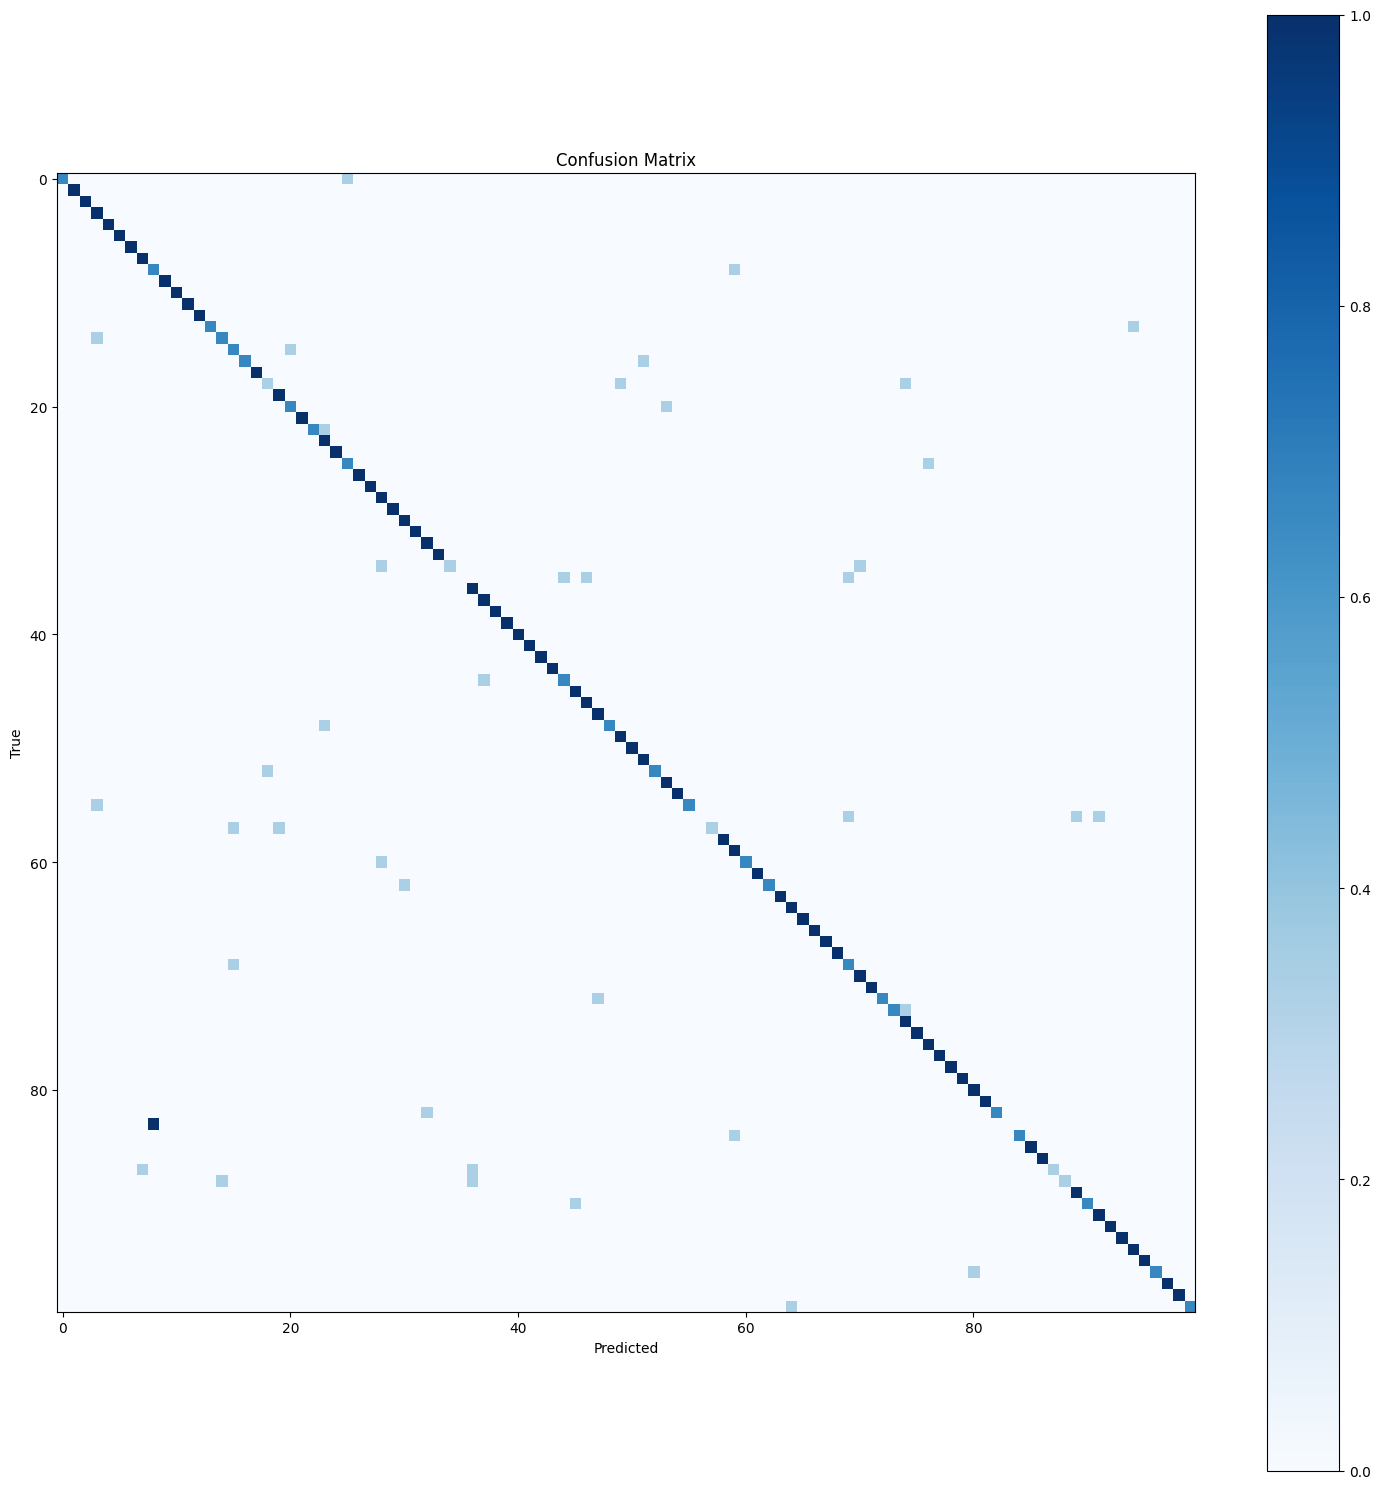

Overall Accuracy: 0.8600


In [30]:
def plot_confusion_matrix(model, dataloader, num_classes=100):
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Normalize by class
    for i in range(num_classes):
        confusion_matrix[i] = confusion_matrix[i] / confusion_matrix[i].sum()

    # Plot
    plt.figure(figsize=(15, 15))
    plt.imshow(confusion_matrix.cpu().numpy(), cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Return overall accuracy
    accuracy = confusion_matrix.diag().sum() / confusion_matrix.sum()
    print(f'Overall Accuracy: {accuracy:.4f}')

    return confusion_matrix

# Generate and plot confusion matrix
conf_matrix = plot_confusion_matrix(trained_model, val_loader)

In [31]:
def predict_test_set(model, test_loader):
    model.eval()
    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, image_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(image_names)):
                predictions.append(preds[i].item())
                filenames.append(image_names[i])

    return filenames, predictions

# Run prediction on test set
test_filenames, test_predictions = predict_test_set(trained_model, test_loader)

clean_filenames = [os.path.splitext(filename)[0] for filename in test_filenames]

# Create a submission file
import pandas as pd
submission = pd.DataFrame({
    'image_name': clean_filenames,
    'pred_label': test_predictions
})

submission = submission.sort_values(
    by='image_name',
    key=lambda x: x.str.extract(r'(\w+)')[0].apply(lambda s: int(s, 16))
)

# Save submission
submission.to_csv(os.path.join(data_root, 'prediction.csv'), index=False)
print("Test predictions saved to 'prediction.csv'")

Test predictions saved to 'prediction.csv'
